##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [4]:
#%pip install pandas
#%pip install matplotlib
#%pip install pyarrow
#%pip install seaborn
#%pip install scipy
#%pip install kmodes
#%pip install plotnine
#%pip install scikit-learn
#%pip install kneed
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [93]:
# Can have as many cells as you want for code
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
import re

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from kmodes.kprototypes import KPrototypes
from plotnine import *
import plotnine

filepath = "./data/catB_train.parquet"
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below.
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [94]:
###...HELPER FUNCTIONS...###
def replace_null_with_num(df, column_name, num=0):
    """
    only for numerical columns
    """
    df[column_name] = df[column_name].fillna(num)
    return df

def replace_null_in_categorical(df, column_name, replacement_value="Undeclared"):
    """
    only for categorical columns
    """
    df[column_name] = df[column_name].fillna(replacement_value)
    return df

def replace_null_with_mean(df, column_name):
    """
    only for numerical columns if data is not skewed
    """
    df[column_name] = df[column_name].fillna(df[column_name].mean())
    return df

def replace_null_with_median(df, column_name):
    """
    only for numerical columns if data is skewed
    """
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    df[column_name] = df[column_name].fillna(df[column_name].median())
    return df


#function to remove 9999
def ave_months(row) :
    valid_months = [month for month in row if month != 9999]
    return np.mean(valid_months) if valid_months else -100


def convertToNumeric(colNames, df):
    cleaned_df = df
    for name in colNames:
        cleaned_df[name] = pd.to_numeric(cleaned_df[name], errors='coerce')
    return cleaned_df

def convertToObject(colNames, df):
    cleaned_df = df
    for name in colNames:
        cleaned_df[name] = cleaned_df[name].astype(str)
    return cleaned_df

def findNA(df):
    for col in df.columns.tolist():
        if df[col].isna().any().any():
            index = df.columns.get_loc(col)
            percent = df[col].isna().sum() / len(df[col]) * 100
            print("index {}: {} still has na values, {}%".format(index, col, percent))

def checkNA(df):
    has_na = df.isna().any().any()
    if has_na:
        print("The DataFrame contains NaN values.")
    else:
        print("The DataFrame does not contain NaN values.")

def dropCols(lst, df):
    cleaned_df = df
    for reg in lst:
        cleaned_df = cleaned_df.drop(cleaned_df.filter(regex=reg).columns, axis=1)
    return cleaned_df

def f_ever_bought_anl(pol_type, df):
    name = 'f_ever_bought_' + pol_type
    done_anl = df.filter(regex=name, axis=1)
    df['count_f_ever_bought_anl_' + pol_type] = done_anl.sum(axis=1)
    return df




## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list).
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [95]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform.

All relevant code MUST be included in this function.'''
    result = []
    cleaned_df = hidden_data.copy()
    cleaned_df = cleaned_df.drop('clntnum', axis = 1)
    cleaned_df = cleaned_df.drop('race_desc', axis = 1)
    tdy_date = pd.to_datetime('2024-01-28')

    cleaned_df['min_occ_date'] = cleaned_df['min_occ_date'].apply(lambda x: (tdy_date - pd.to_datetime(x)).days if x != 'None' else -100)
    

    #Rename 'min_occ_date' according to how it was transformed
    cleaned_df = cleaned_df.rename(columns={'min_occ_date': 'days_since_min_occ_date'})
    cleaned_df = cleaned_df.drop(columns = ['ctrycode_desc'], axis = 1)
    # Replaced null values with 0. By inference, null values likely mean the
    #  characteristic does not apply to that customer
    replace_null_with_num(cleaned_df, 'f_ever_declined_la')
    replace_null_with_num(cleaned_df, 'recency_lapse')
    replace_null_with_num(cleaned_df, 'recency_cancel')
    replace_null_with_num(cleaned_df, 'tot_cancel_pols')

    #Replaced null values in categorical data with 'Undeclared' by default or otherwise
    #  specified in the argument.
    replace_null_in_categorical(cleaned_df, "cltsex_fix", "Others")
    replace_null_in_categorical(cleaned_df, "hh_size_est")
    replace_null_in_categorical(cleaned_df, "annual_income_est")

    #Replaced null values in numerical data with mean or median depending on
    #  whether data is skewed
    replace_null_with_median(cleaned_df, "hh_20")
    replace_null_with_median(cleaned_df, "pop_20")
    replace_null_with_mean(cleaned_df, "hh_size")

    #Replaced null values in binary data with 2 to indicate another category
    replace_null_with_num(cleaned_df, "flg_substandard", 2)
    replace_null_with_num(cleaned_df, "flg_is_borderline_standard", 2)
    replace_null_with_num(cleaned_df, "flg_is_revised_term", 2)
    replace_null_with_num(cleaned_df, "flg_is_rental_flat", 2)
    replace_null_with_num(cleaned_df, "flg_has_health_claim", 2)
    replace_null_with_num(cleaned_df, "flg_has_life_claim", 2)
    replace_null_with_num(cleaned_df, "flg_gi_claim", 2)
    replace_null_with_num(cleaned_df, "flg_is_proposal", 2)
    replace_null_with_num(cleaned_df, "flg_with_preauthorisation", 2)
    replace_null_with_num(cleaned_df, "flg_is_returned_mail", 2)
    replace_null_with_num(cleaned_df, "is_consent_to_mail", 2)
    replace_null_with_num(cleaned_df, "is_consent_to_email", 2)
    replace_null_with_num(cleaned_df, "is_consent_to_call", 2)
    replace_null_with_num(cleaned_df, "is_consent_to_sms", 2)
    replace_null_with_num(cleaned_df, "is_valid_dm", 2)
    replace_null_with_num(cleaned_df, "is_valid_email", 2)
    replace_null_with_num(cleaned_df, "is_housewife_retiree", 2)
    replace_null_with_num(cleaned_df, "is_sg_pr", 2)
    replace_null_with_num(cleaned_df, "is_class_1_2", 2)
    replace_null_with_num(cleaned_df, "is_dependent_in_at_least_1_policy", 2)

    cleaned_df = cleaned_df.drop(columns = ["cltsex_fix", "flg_is_revised_term", "flg_is_returned_mail"], axis = 1)

    consent_cols = ['is_consent_to_mail','is_consent_to_email', 'is_consent_to_call',	'is_consent_to_sms']
    cleaned_df['is_contactable'] = cleaned_df[consent_cols].any(axis=1).astype(object)

    cleaned_df = cleaned_df.drop(columns = consent_cols, axis = 1)
    
    valid_cols = ['is_valid_dm', 'is_valid_email']
    cleaned_df['is_valid'] = cleaned_df[valid_cols].any(axis=1).astype(object)
    cleaned_df = cleaned_df.drop(columns = valid_cols, axis = 1)

    demographics_cols_to_drop = ['is_class_1_2', 'is_housewife_retiree', 'is_dependent_in_at_least_1_policy' , 'hh_20', 'pop_20', 'hh_size_est']
    cleaned_df = cleaned_df.drop(columns = demographics_cols_to_drop, axis = 1) 

    # Redundant columns identified to drop
    lst = ['c4bda5$', '32c74c', '^prempaid_', '^f_hold_', 'ape_839f8a', '^ape_e22a6a$','^ape_d0adeb$','ape_507c37',
       'sumins_839f8a', 'sumins_e22a6a', 'sumins_d0adeb', 'sumins_507c37', 'f_ever_bought_839f8a', 
       'f_ever_bought_e22a6a', 'f_ever_bought_d0adeb', 'f_ever_bought_507c37', 'n_months_last_bought_839f8a', 
       'n_months_last_bought_e22a6a', 'n_months_last_bought_d0adeb', 'n_months_last_bought_507c37', '^ape_ltc$',
       '^ape_gi$','^sumins_ltc$','^sumins_gi$','^f_ever_bought_ltc$', '^f_ever_bought_gi$', '^n_months_last_bought_ltc$',
       '^n_months_last_bought_gi$']

    cleaned_df = dropCols(lst, cleaned_df)

    ape_gi_df = cleaned_df.filter(regex= '^ape_gi_')
    ape_lh_df = cleaned_df.filter(regex= '^ape_lh_')
    ape_ltc_df = cleaned_df.filter(regex= '^ape_ltc_')
    ape_grp_df = cleaned_df.filter(regex= '^ape_grp_')
    ape_inv_df = cleaned_df.filter(regex= '^ape_inv_')

    # Adding aggregated ape column
    cleaned_df['tot_ape_gi'] = ape_gi_df.sum(axis=1)
    cleaned_df['tot_ape_lh'] = ape_lh_df.sum(axis=1)
    cleaned_df['tot_ape_ltc'] = ape_ltc_df.sum(axis=1)
    cleaned_df['tot_ape_grp'] = ape_grp_df.sum(axis=1)
    cleaned_df['tot_ape_inv'] = ape_inv_df.sum(axis=1)

    # Removing individual policy ape
    ape_columns_to_drop = []
    [ape_columns_to_drop.extend(df.columns.tolist()) for df in [ape_gi_df, ape_lh_df, ape_ltc_df, 
                                                                ape_grp_df, ape_inv_df]]


    sumins_gi_df = cleaned_df.filter(regex= '^sumins_gi_')
    sumins_lh_df = cleaned_df.filter(regex= '^sumins_lh_')
    sumins_ltc_df = cleaned_df.filter(regex= '^sumins_ltc_')
    sumins_grp_df = cleaned_df.filter(regex= '^sumins_grp_')
    sumins_inv_df = cleaned_df.filter(regex= '^sumins_inv_')

    # Adding aggregated ape column

    cleaned_df['tot_sumsin_gi'] = sumins_gi_df.sum(axis=1)
    cleaned_df['tot_sumsin_lh'] = sumins_lh_df.sum(axis=1)
    cleaned_df['tot_sumsin_ltc'] = sumins_ltc_df.sum(axis=1)
    cleaned_df['tot_sumsin_grp'] = sumins_grp_df.sum(axis=1)
    cleaned_df['tot_sumsin_inv'] = sumins_inv_df.sum(axis=1)

    sumins_columns_to_drop = []
    [sumins_columns_to_drop.extend(df.columns.tolist()) for df in [sumins_gi_df, sumins_lh_df, sumins_ltc_df, 
                                                                   sumins_grp_df, sumins_inv_df]]

    #filtering

    n_months_last_bought_filter = cleaned_df.filter(regex='n_months_last_bought', axis=1)
    n_months_last_bought_lh = cleaned_df.filter(regex='n_months_last_bought_lh', axis=1)
    n_months_last_bought_grp = cleaned_df.filter(regex='n_months_last_bought_grp', axis=1)
    n_months_last_bought_inv = cleaned_df.filter(regex='n_months_last_bought_inv', axis=1)



    #change dataset to numeric then apply fn
    n_months_last_bought_lh = n_months_last_bought_lh.apply(pd.to_numeric, errors='coerce')
    n_months_last_bought_lh['Avg_Months_Last_Bought_lh'] = n_months_last_bought_lh.apply(ave_months, axis=1)

    n_months_last_bought_grp = n_months_last_bought_grp.apply(pd.to_numeric, errors='coerce')
    n_months_last_bought_grp['Avg_Months_Last_Bought_grp'] = n_months_last_bought_grp.apply(ave_months, axis=1)

    n_months_last_bought_inv = n_months_last_bought_inv.apply(pd.to_numeric, errors='coerce')
    n_months_last_bought_inv['Avg_Months_Last_Bought_inv'] = n_months_last_bought_inv.apply(ave_months, axis=1)


    #convert float to object type
    cleaned_df['flg_affconnect_show_interest_ever'] = cleaned_df['flg_affconnect_show_interest_ever'].astype('object')
    cleaned_df['flg_affconnect_ready_to_buy_ever'] = cleaned_df['flg_affconnect_ready_to_buy_ever'].astype('object')
    cleaned_df['flg_affconnect_lapse_ever'] = cleaned_df['flg_affconnect_lapse_ever'].astype('object')
    cleaned_df['flg_hlthclaim_839f8a_ever'] = cleaned_df['flg_hlthclaim_839f8a_ever'].astype('object')
    cleaned_df['flg_hlthclaim_14cb37_ever'] = cleaned_df['flg_hlthclaim_14cb37_ever'].astype('object')
    cleaned_df['flg_hlthclaim_14cb37_ever'] = cleaned_df['flg_hlthclaim_14cb37_ever'].astype('object')

    #convert some object cols to float 
    cleaned_df['hlthclaim_amt'] = cleaned_df['hlthclaim_amt'].astype('float')
    cleaned_df['giclaim_amt'] = cleaned_df['giclaim_amt'].astype('float')


    #fill NaN in flag cols with 2
    cleaned_df['flg_affconnect_show_interest_ever'] = cleaned_df['flg_affconnect_show_interest_ever'].fillna(2)
    cleaned_df['flg_affconnect_ready_to_buy_ever'] = cleaned_df['flg_affconnect_ready_to_buy_ever'].fillna(2)
    cleaned_df['flg_affconnect_lapse_ever'] = cleaned_df['flg_affconnect_lapse_ever'].fillna(2)
    cleaned_df['flg_hlthclaim_839f8a_ever'] = cleaned_df['flg_hlthclaim_839f8a_ever'].fillna(2)
    cleaned_df['flg_hlthclaim_14cb37_ever'] = cleaned_df['flg_hlthclaim_14cb37_ever'].fillna(2)

    #cols to drop -  dropping individual policies
    n_months_last_bought_cols_to_drop = ['n_months_last_bought_']

    n_months_since_lapse_cols_to_be_dropped = ['^n_months_since_lapse_']

    #creation of agg columns
    polTypeList = ['ltc', 'grp', 'inv', 'lh']

    for polType in polTypeList :
        cleaned_df = f_ever_bought_anl(polType, cleaned_df)
        cleaned_df['count_f_ever_bought_anl_' + polType] = cleaned_df['count_f_ever_bought_anl_' + polType].astype('object')

    f_ever_bought_cols_to_drop =['^f_ever_bought_']

    na_cols_to_be_dropped = hidden_data.iloc[:,278:303].columns.to_list()

    cols_to_be_dropped = ape_columns_to_drop + sumins_columns_to_drop + n_months_last_bought_cols_to_drop + f_ever_bought_cols_to_drop + n_months_since_lapse_cols_to_be_dropped + na_cols_to_be_dropped
    len(cols_to_be_dropped)

    columns_to_drop = cleaned_df.filter(regex='|'.join(cols_to_be_dropped)).columns
    columns_to_drop.tolist()

    cleaned_df = cleaned_df.drop(columns = columns_to_drop)

    colsToNumeric = ['tot_ape_gi','tot_ape_lh','tot_ape_ltc', 'tot_ape_grp' ,'tot_ape_inv'
    , 'tot_sumsin_gi', 'tot_sumsin_lh', 'tot_sumsin_ltc', 'tot_sumsin_grp', 'tot_sumsin_inv', 
    'count_f_ever_bought_anl_ltc', 'count_f_ever_bought_anl_grp', 'count_f_ever_bought_anl_inv',
    'count_f_ever_bought_anl_lh', 'days_since_min_occ_date'] 

    colsToObject = ['flg_substandard', 'flg_is_borderline_standard',
                'flg_is_rental_flat', 'flg_has_health_claim', 'flg_has_life_claim', 'flg_gi_claim', 
                'flg_is_proposal', 'flg_with_preauthorisation', 'is_sg_pr',
                'f_ever_declined_la', 'flg_latest_being_lapse',
                'flg_latest_being_cancel']
    
    def convertToObject(colNames, df):
        cleaned_df = df
        for name in colNames:
            cleaned_df[name] = cleaned_df[name].astype(str)
        return cleaned_df

    cleaned_df = convertToNumeric(colsToNumeric, cleaned_df)
    cleaned_df = convertToObject(colsToObject, cleaned_df)

        
    # Get the position of categorical columns
    categorical_indices = [cleaned_df.columns.get_loc(col) for col in cleaned_df.select_dtypes(include='object').columns]

    numeric_matrix = cleaned_df.drop(cleaned_df.columns[categorical_indices], axis=1)
    categorical_matrix = cleaned_df.iloc[:, categorical_indices].values
    
    dfMatrix = cleaned_df.to_numpy()

    # Get the position of categorical columns
    categorical_indices = [cleaned_df.columns.get_loc(col) for col in cleaned_df.select_dtypes(include='object').columns]

    # Extract numeric and categorical matrices
    numeric_matrix = cleaned_df.drop(cleaned_df.columns[categorical_indices], axis=1)
    categorical_matrix = cleaned_df.iloc[:, categorical_indices]

    # Concatenate numeric and categorical matrices into a single DataFrame
    combined_df = pd.concat([numeric_matrix, categorical_matrix], axis=1)

    # Fit the cluster
    kprototype =  KPrototypes(n_clusters=2, init='Huang', verbose=2, random_state=42)
    kprototype.fit_predict(dfMatrix, categorical = categorical_indices)
    
    cluster_labels = kprototype.labels_

    return cluster_labels

##### Cell to check testing_hidden_data function

In [96]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

/var/folders/s8/h576kn8n48vd37_dt88pwm0w0000gn/T/ipykernel_21092/754033476.py:159: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/var/folders/s8/h576kn8n48vd37_dt88pwm0w0000gn/T/ipykernel_21092/754033476.py:160: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/var/folders/s8/h576kn8n48vd37_dt88pwm0w0000gn/T/ipykernel_21092/754033476.py:161: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_optio

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 802, ncost: 1.1642657956830154e+16
Run: 1, iteration: 2/100, moves: 280, ncost: 1.1609235731846382e+16
Run: 1, iteration: 3/100, moves: 97, ncost: 1.1549899189058098e+16
Run: 1, iteration: 4/100, moves: 1054, ncost: 8162448405449954.0
Run: 1, iteration: 5/100, moves: 1075, ncost: 6494785549791221.0
Run: 1, iteration: 6/100, moves: 206, ncost: 6389681990183872.0
Run: 1, iteration: 7/100, moves: 46, ncost: 6384052641556088.0
Run: 1, iteration: 8/100, moves: 3, ncost: 6384025687799051.0
Run: 1, iteration: 9/100, moves: 0, ncost: 6384025687799051.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 3151, ncost: 7498917819753619.0
Run: 2, iteration: 2/100, moves: 858, ncost: 6469421247205701.0
Run: 2, iteration: 3/100, moves: 192, ncost: 6388602948227020.0
Run: 2, iteration: 4/100, moves: 41, ncost: 6384052641556088.0


# Analysing Columns Related to General Client Information, Client Risk and Status Indicators, Client Consent and Communication Preferences and Demographic and Household Information

In [9]:
cleaned_df = test_df.copy()

In [10]:
cleaned_df = cleaned_df.drop('clntnum', axis = 1)

We drop client nmbr as it is a unique identifier and will not be relevant in predicting the target label.


In [11]:
cleaned_df = cleaned_df.drop('race_desc', axis = 1)

We also drop the racial description as we do not have any intuition in how being a certain race can influence a client's decision to buy insurance. We will use other factual information to determine and predict the target label

In [12]:
#functions to handle null values
def plot_nulls(df):
    # Calculate the percentage of missing values in each column
    missing_percentage = (df.isnull().sum() / len(df)) * 100

    # Plotting the null values using Matplotlib
    plt.bar(missing_percentage.index, missing_percentage)

    # Adding labels and title
    plt.xlabel('Columns')
    plt.ylabel('Percentage of Missing Values')
    plt.title('Missing Values in Each Column')

    # Rotating x-axis labels for better readability
    plt.xticks(rotation=90, ha='right', fontsize=8)

    # Adjusting layout for better spacing
    plt.tight_layout()

    # Display the plot
    plt.show()

def replace_null_with_num(df, column_name, num=0):
    """
    only for numerical columns
    """
    df[column_name] = df[column_name].fillna(num)
    return df

def replace_null_in_categorical(df, column_name, replacement_value="Undeclared"):
    """
    only for categorical columns
    """
    df[column_name] = df[column_name].fillna(replacement_value)
    return df

def replace_null_with_mean(df, column_name):
    """
    only for numerical columns if data is not skewed
    """
    df[column_name] = df[column_name].fillna(df[column_name].mean())
    return df

def replace_null_with_median(df, column_name):
    """
    only for numerical columns if data is skewed
    """
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    df[column_name] = df[column_name].fillna(df[column_name].median())
    return df

In [13]:
#convert min_occ_date to duration in days

tdy_date = pd.to_datetime('2024-01-28')

cleaned_df['min_occ_date'] = cleaned_df['min_occ_date'].apply(lambda x: (tdy_date - pd.to_datetime(x)).days if x != 'None' else -100)
print(cleaned_df['min_occ_date'].value_counts())

#Rename 'min_occ_date' according to how it was transformed
cleaned_df = cleaned_df.rename(columns={'min_occ_date': 'days_since_min_occ_date'})


min_occ_date
392      1168
2614      180
545       178
2675      159
302       143
         ... 
13036       1
4712        1
3356        1
1015        1
12367       1
Name: count, Length: 4576, dtype: int64


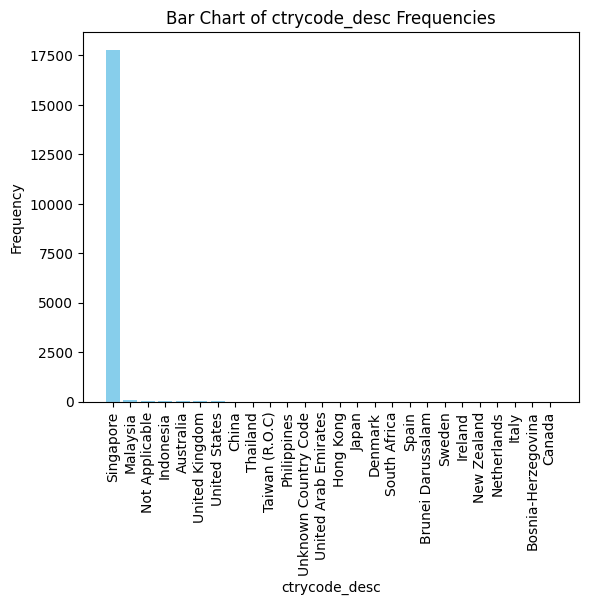

In [14]:
#drop columns with similar data
#drop `ctrycode_desc` as data is not meaningful?

# Compute the frequency using value_counts
frequency = cleaned_df['ctrycode_desc'].value_counts()

# Plotting the bar chart using Matplotlib
plt.bar(frequency.index, frequency.values, color='skyblue')

# Adding labels and title
plt.xlabel('ctrycode_desc')
plt.ylabel('Frequency')
plt.title('Bar Chart of ctrycode_desc Frequencies')

# Rotating x-axis labels vertically
plt.xticks(rotation='vertical')

# Display the plot
plt.show()

In [15]:
#Drop 'ctrycode_desc' as it does not add significant information
cleaned_df = cleaned_df.drop(columns = ['ctrycode_desc'], axis = 1)

In [16]:
#Pipeline to replace null values

# Replaced null values with 0. By inference, null values likely mean the
#  characteristic does not apply to that customer
replace_null_with_num(cleaned_df, 'f_ever_declined_la')
replace_null_with_num(cleaned_df, 'recency_lapse')
replace_null_with_num(cleaned_df, 'recency_cancel')
replace_null_with_num(cleaned_df, 'tot_cancel_pols')

#Replaced null values in categorical data with 'Undeclared' by default or otherwise
#  specified in the argument.
replace_null_in_categorical(cleaned_df, "cltsex_fix", "Others")
replace_null_in_categorical(cleaned_df, "hh_size_est")
replace_null_in_categorical(cleaned_df, "annual_income_est")

#Replaced null values in numerical data with mean or median depending on
#  whether data is skewed
replace_null_with_median(cleaned_df, "hh_20")
replace_null_with_median(cleaned_df, "pop_20")
replace_null_with_mean(cleaned_df, "hh_size")

#Replaced null values in binary data with 2 to indicate another category
replace_null_with_num(cleaned_df, "flg_substandard", 2)
replace_null_with_num(cleaned_df, "flg_is_borderline_standard", 2)
replace_null_with_num(cleaned_df, "flg_is_revised_term", 2)
replace_null_with_num(cleaned_df, "flg_is_rental_flat", 2)
replace_null_with_num(cleaned_df, "flg_has_health_claim", 2)
replace_null_with_num(cleaned_df, "flg_has_life_claim", 2)
replace_null_with_num(cleaned_df, "flg_gi_claim", 2)
replace_null_with_num(cleaned_df, "flg_is_proposal", 2)
replace_null_with_num(cleaned_df, "flg_with_preauthorisation", 2)
replace_null_with_num(cleaned_df, "flg_is_returned_mail", 2)
replace_null_with_num(cleaned_df, "is_consent_to_mail", 2)
replace_null_with_num(cleaned_df, "is_consent_to_email", 2)
replace_null_with_num(cleaned_df, "is_consent_to_call", 2)
replace_null_with_num(cleaned_df, "is_consent_to_sms", 2)
replace_null_with_num(cleaned_df, "is_valid_dm", 2)
replace_null_with_num(cleaned_df, "is_valid_email", 2)
replace_null_with_num(cleaned_df, "is_housewife_retiree", 2)
replace_null_with_num(cleaned_df, "is_sg_pr", 2)
replace_null_with_num(cleaned_df, "is_class_1_2", 2)
replace_null_with_num(cleaned_df, "is_dependent_in_at_least_1_policy", 2)

,clttype,stat_flag,days_since_min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,flg_is_revised_term,flg_is_rental_flat,flg_has_health_claim,...,giclaim_amt,recency_giclaim,giclaim_cnt_success,recency_giclaim_success,giclaim_cnt_unsuccess,recency_giclaim_unsuccess,flg_gi_claim_29d435_ever,flg_gi_claim_058815_ever,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever
19550,P,ACTIVE,2280,1974-05-09,Female,0.0,0.0,0.0,0.0,0.0,...,None,NaN,None,None,None,None,None,None,None,None
4600,P,ACTIVE,6094,1979-11-11,Male,0.0,0.0,0.0,0.0,0.0,...,None,NaN,None,None,None,None,None,None,None,None
13337,P,ACTIVE,1611,1976-01-28,Male,0.0,0.0,0.0,0.0,0.0,...,None,NaN,None,None,None,None,None,None,None,None
15074,P,ACTIVE,832,1976-03-19,Female,0.0,0.0,0.0,0.0,0.0,...,None,NaN,None,None,None,None,None,None,None,None
19724,P,ACTIVE,2018,1995-07-31,Female,0.0,0.0,0.0,0.0,0.0,...,None,NaN,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,P,LAPSED,2736,1994-05-24,Male,0.0,0.0,0.0,0.0,0.0,...,None,NaN,None,None,None,None,None,None,None,None
11964,P,ACTIVE,12367,1948-12-16,Male,0.0,0.0,0.0,0.0,0.0,...,None,NaN,None,None,None,None,None,None,None,None
5390,P,ACTIVE,5872,1967-12-06,Female,0.0,0.0,0.0,0.0,0.0,...,None,NaN,None,None,None,None,None,None,None,None
860,P,ACTIVE,5993,1986-04-01,Male,0.0,0.0,0.0,0.0,0.0,...,None,NaN,None,None,None,None,None,None,None,None


# Client Risk and status indicators

We have decided to drop the "cltsex_fix", "flg_is_revised_term", "flg_is_returned_mail" columns as we feel like it is irrelevant in helping to determine whether a customer would buy insurance from a logical standpoint

In [17]:
cleaned_df = cleaned_df.drop(columns = ["cltsex_fix", "flg_is_revised_term", "flg_is_returned_mail"], axis = 1)

# Client Consent and Communication Preferences

All customers have specified whether they consent to being contacted via one of the four means, mail, email, calling or sms. In this case, we decided to compress these 4 columns to a general is_contactable column where the label would be 1 if there is at least 1 way to contact the client. We do the same for whether the customer information is valid or not. This is an indicator of whether a client can be contacted easily by the agency, and clients with contactable information are likely to have a good relationship with the organisation and may be more likely to purchase insurance plans.

In [18]:
consent_cols = ['is_consent_to_mail','is_consent_to_email', 'is_consent_to_call',	'is_consent_to_sms']
cleaned_df['is_contactable'] = cleaned_df[consent_cols].any(axis=1).astype(object)

cleaned_df = cleaned_df.drop(columns = consent_cols, axis = 1)

In [19]:
valid_cols = ['is_valid_dm', 'is_valid_email']
cleaned_df['is_valid'] = cleaned_df[valid_cols].any(axis=1).astype(object)

cleaned_df = cleaned_df.drop(columns = valid_cols, axis = 1)

# Customer Demographic

In [20]:
cleaned_df['is_housewife_retiree'].value_counts()


is_housewife_retiree
0.0    16924
2.0     1014
1.0       54
Name: count, dtype: int64

As majority of the data shows that the customers are not a housewife retiree, 17k rows as compared to 54 (excluding the missing data labelled as 2), we decide to drop this column.

In [21]:
cleaned_df['is_sg_pr'].value_counts()

is_sg_pr
1.0    15593
0.0     1385
2.0     1014
Name: count, dtype: int64

Majority of the clients are SG / PR, with approximately 1k rows of missing data. We will retain this column as we believe that a client being a resident of Singapore could influence their decision ot purchase a life / health insurance.

In [22]:
cleaned_df['is_class_1_2'].value_counts()

is_class_1_2
1.0    9051
0.0    7927
2.0    1014
Name: count, dtype: int64

As we do not understand the meaning behind class 1 or class 2, we have decided to drop this column.

In [23]:
cleaned_df['is_dependent_in_at_least_1_policy'].value_counts()

is_dependent_in_at_least_1_policy
0.0    16978
2.0     1014
Name: count, dtype: int64

Seems like out of all the non-na records, 100% of the customers are not dependent in at least 1 policy. We decide to drop this column as we currently do not have any individuals who are dependent in at least 1 policy

In [24]:
print('Mean hh size: ', cleaned_df['hh_size'].mean())
cleaned_df['hh_size'].value_counts()

Mean hh size:  3.235774807689279


hh_size
3.235775    2809
3.000000     676
1.000000     502
2.000000     341
4.000000     287
            ... 
2.897059       1
3.101562       1
2.973856       1
3.098361       1
3.211765       1
Name: count, Length: 4935, dtype: int64

For household information, we decided to only retain the column hh_size as it gives us an interpretable and general metric to simplify the client's household information.

In [25]:
demographics_cols_to_drop = ['is_class_1_2', 'is_housewife_retiree', 'is_dependent_in_at_least_1_policy' , 'hh_20', 'pop_20', 'hh_size_est']
cleaned_df = cleaned_df.drop(columns = demographics_cols_to_drop, axis = 1)

# Other income insights

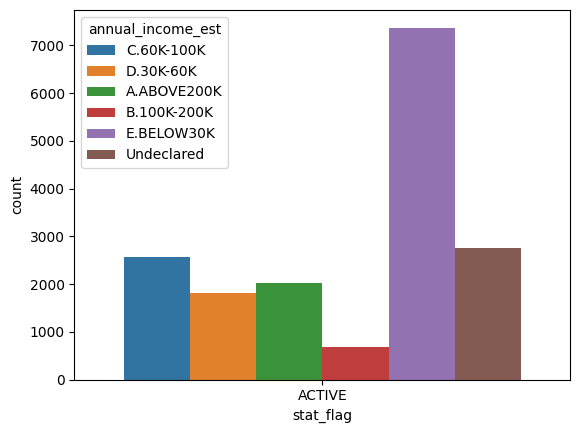

In [26]:
#find income demographic of active customers
active_df = cleaned_df[cleaned_df['stat_flag'] == 'ACTIVE']
cp = sns.countplot(x="stat_flag", hue="annual_income_est", data=active_df)

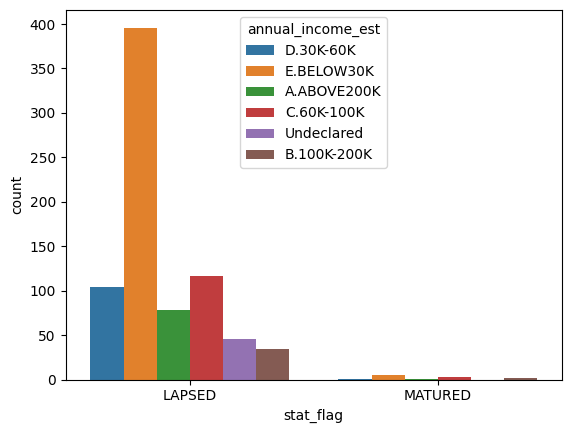

In [27]:
non_active_df = cleaned_df[cleaned_df['stat_flag'] != 'ACTIVE']
cp = sns.countplot(x="stat_flag", hue="annual_income_est", data=non_active_df)

From the bar plots above, it is evident that the insurance company's customer base, both active and non-active, is largely made up of people who's annual income falls below 30k. Thus, it would be in the company's interest to understand this particular demographic of customers and perhaps even curate special policies targeted towards them.

<Axes: xlabel='annual_income_est'>

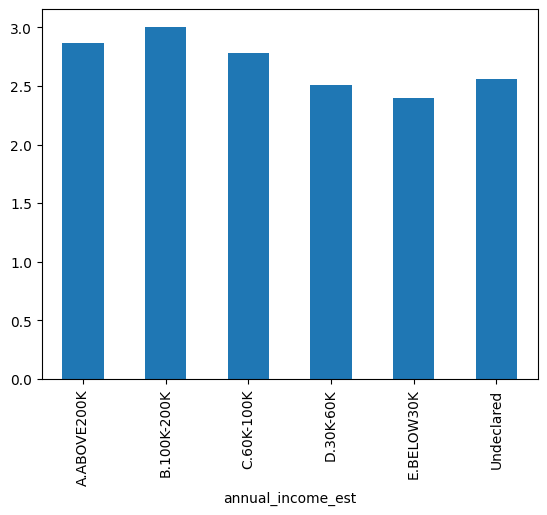

In [28]:
#find demographic that buys the most policies
df_groups = active_df.groupby(['annual_income_est'])['tot_inforce_pols'].mean()
df_groups.plot(kind='bar')

From the bar plot above, the average number of policies bought by the various income demographics are not significantly different. All demographics fall within the range of buying around 2 to 3 policies. Hence, the demographic that would bring the most profit to the company would be those with an annual income estimate below 100k - 200k.

# Analysing Correlation between APE_XX and Prempaid_XX

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


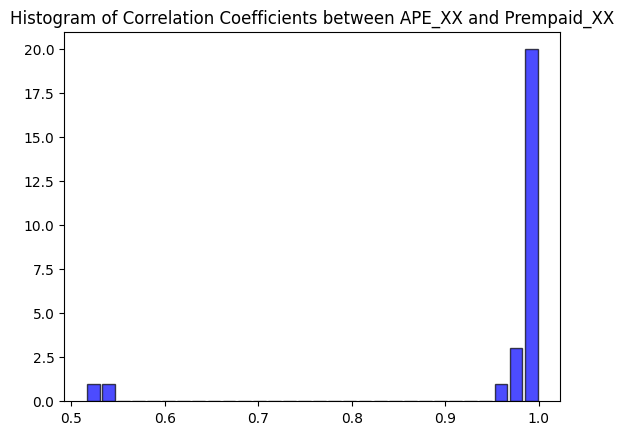

The average correlation between the APE and Prempaid of policies is 0.95781799257137


In [29]:
selected_columns = cleaned_df.filter(regex='^ape_', axis=1).join(cleaned_df.filter(regex='^prempaid_', axis=1))

# Iterate through columns starting with 'ape_'
correlation_list = []

for col in cleaned_df.filter(regex='^ape_', axis=1):
    id1 = col.split("ape_", 1)[-1]

    # Iterate through columns starting with 'prempaid_'
    for o in cleaned_df.filter(regex='^prempaid_', axis=1):
        id2 = o.split("prempaid_", 1)[-1]

        if id1 == id2:
            test_col = pd.to_numeric(cleaned_df[col], errors='coerce').dropna()
            against = pd.to_numeric(cleaned_df[o], errors='coerce').dropna()

            correlation_value, _ = pearsonr(test_col, against)
            #print("Correlation between {} and {} is {}".format(col, o, correlation_value))


            if (not np.isnan(correlation_value)): 
                correlation_list.append(correlation_value)

avg_correlation = sum(correlation_list) / len(correlation_list)

#Histogram of Correlation Coefficients between APE_XX and Prempaid_XX
plt.hist(correlation_list, bins=30, color='blue', edgecolor='black', alpha=0.7, rwidth=0.85)
plt.title("Histogram of Correlation Coefficients between APE_XX and Prempaid_XX")
plt.show()

print("The average correlation between the APE and Prempaid of policies is {}".format(avg_correlation))

Due to a high correlation (almost perfect) between APE and Prempaid across all policies, we decided to drop the prempaid columns.

# Analysing Correlation between APE_XX and Sumins_XX

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


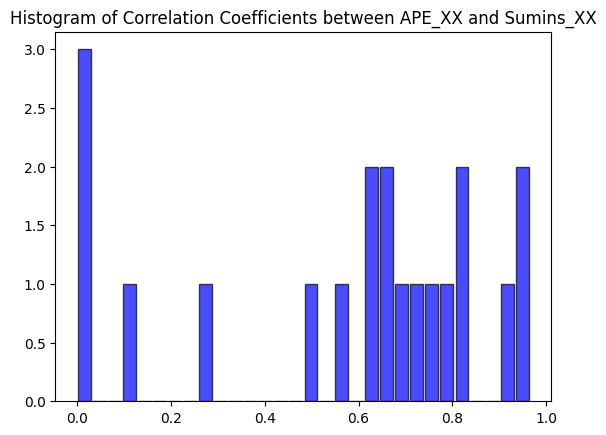

In [30]:
selected_columns = cleaned_df.filter(regex='^ape_', axis=1).join(cleaned_df.filter(regex='^prempaid_', axis=1))
cor = []
# Iterate through columns starting with 'ape_'
for col in cleaned_df.filter(regex='^ape_', axis=1):
    id1 = col.split("ape_", 1)[-1]

    # Iterate through columns starting with 'sumins'
    for o in cleaned_df.filter(regex='^sumins_', axis=1):
        id2 = o.split("sumins_", 1)[-1]

        if id1 == id2:
            test_col = pd.to_numeric(cleaned_df[col], errors='coerce').dropna()
            against = pd.to_numeric(cleaned_df[o], errors='coerce').dropna()

            correlation_value, _ = pearsonr(test_col, against)
            if correlation_value != None:
                cor.append(correlation_value)
            # print("Correlation between {} and {} is {}".format(col, o, correlation_value))

#Histogram of Correlation Coefficients between APE_XX and Sumins_XX
plt.title("Histogram of Correlation Coefficients between APE_XX and Sumins_XX")
plt.hist(cor, bins=30, color='blue', edgecolor='black', alpha=0.7, rwidth=0.85)
plt.show()

The correlation between sumins_XX and ape_XX seem to be varied, hence we will not drop sumins.

There are duplicate columns for the 4 insurance policies (839f8a, e22a6a, d0adeb, 507c37) across the datasets, hence we have decided to remove these duplicated columns.

Also, there are 5 policy types (ltc, gi, lh, grp, inv), but there seems to be generic columns for XX_ltc and XX_gi (e.g. ape_ltc and n_months_last_bought_gi) that is not tagged to any policy ids. Since we do not know the nature of these columns and whether it is an aggregated measure, we will drop these generic columns and perform our own aggregations on the individual policy ids.

# Dropping Columns by Column Inspection

In [31]:
lst = ['c4bda5$', '32c74c', '^prempaid_', '^f_hold_', 'ape_839f8a', '^ape_e22a6a$','^ape_d0adeb$','ape_507c37',
       'sumins_839f8a', 'sumins_e22a6a', 'sumins_d0adeb', 'sumins_507c37', 'f_ever_bought_839f8a', 
       'f_ever_bought_e22a6a', 'f_ever_bought_d0adeb', 'f_ever_bought_507c37', 'n_months_last_bought_839f8a', 
       'n_months_last_bought_e22a6a', 'n_months_last_bought_d0adeb', 'n_months_last_bought_507c37', '^ape_ltc$',
       '^ape_gi$','^sumins_ltc$','^sumins_gi$','^f_ever_bought_ltc$', '^f_ever_bought_gi$', '^n_months_last_bought_ltc$',
       '^n_months_last_bought_gi$']

def dropCols(lst, df):
    cleaned_df = df
    for reg in lst:
        cleaned_df = cleaned_df.drop(cleaned_df.filter(regex=reg).columns, axis=1)
    return cleaned_df

cleaned_df = dropCols(lst, cleaned_df)

# Aggregating APE and Sumins

Aggregating APE by summing across all policies and grouping them into respective policy types

In [32]:
ape_gi_df = cleaned_df.filter(regex= '^ape_gi_')
ape_lh_df = cleaned_df.filter(regex= '^ape_lh_')
ape_ltc_df = cleaned_df.filter(regex= '^ape_ltc_')
ape_grp_df = cleaned_df.filter(regex= '^ape_grp_')
ape_inv_df = cleaned_df.filter(regex= '^ape_inv_')

# Adding aggregated ape column
cleaned_df['tot_ape_gi'] = ape_gi_df.sum(axis=1)
cleaned_df['tot_ape_lh'] = ape_lh_df.sum(axis=1)
cleaned_df['tot_ape_ltc'] = ape_ltc_df.sum(axis=1)
cleaned_df['tot_ape_grp'] = ape_grp_df.sum(axis=1)
cleaned_df['tot_ape_inv'] = ape_inv_df.sum(axis=1)

# Removing individual policy ape
ape_columns_to_drop = []
[ape_columns_to_drop.extend(df.columns.tolist()) for df in [ape_gi_df, ape_lh_df, ape_ltc_df, ape_grp_df, ape_inv_df]]

[None, None, None, None, None]

In [33]:
sumins_gi_df = cleaned_df.filter(regex= '^sumins_gi_')
sumins_lh_df = cleaned_df.filter(regex= '^sumins_lh_')
sumins_ltc_df = cleaned_df.filter(regex= '^sumins_ltc_')
sumins_grp_df = cleaned_df.filter(regex= '^sumins_grp_')
sumins_inv_df = cleaned_df.filter(regex= '^sumins_inv_')

# Adding aggregated ape column

cleaned_df['tot_sumsin_gi'] = sumins_gi_df.sum(axis=1)
cleaned_df['tot_sumsin_lh'] = sumins_lh_df.sum(axis=1)
cleaned_df['tot_sumsin_ltc'] = sumins_ltc_df.sum(axis=1)
cleaned_df['tot_sumsin_grp'] = sumins_grp_df.sum(axis=1)
cleaned_df['tot_sumsin_inv'] = sumins_inv_df.sum(axis=1)

# Removing individual policy ape
sumins_columns_to_drop = []
[sumins_columns_to_drop.extend(df.columns.tolist()) for df in [sumins_gi_df, sumins_lh_df, sumins_ltc_df, sumins_grp_df, sumins_inv_df]]

[None, None, None, None, None]

# Analysis Number of Months Since last bought policy

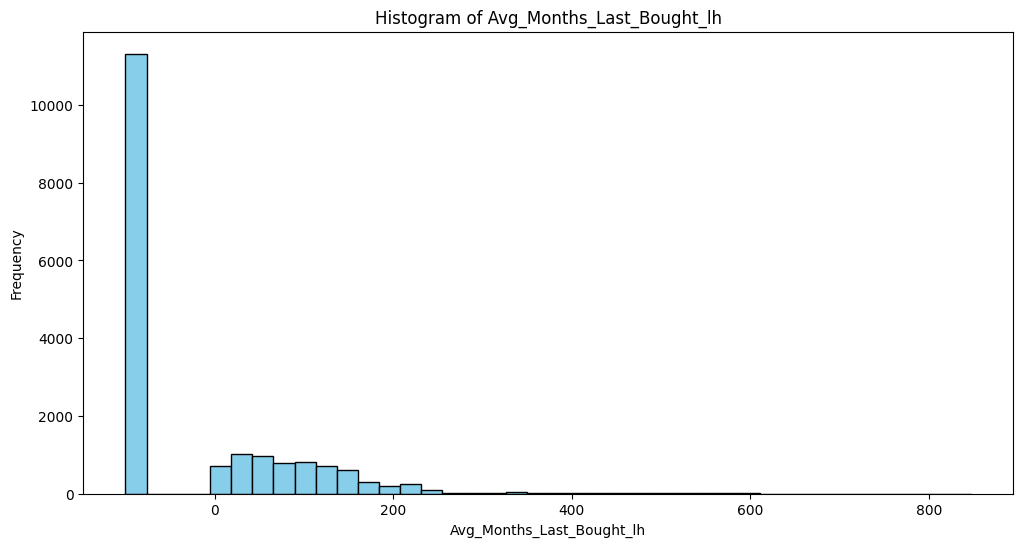

In [34]:

#filtering
pd.set_option('display.max_columns', None)
n_months_last_bought_filter = cleaned_df.filter(regex='n_months_last_bought', axis=1)
n_months_last_bought_lh = cleaned_df.filter(regex='n_months_last_bought_lh', axis=1)
n_months_last_bought_grp = cleaned_df.filter(regex='n_months_last_bought_grp', axis=1)
n_months_last_bought_inv = cleaned_df.filter(regex='n_months_last_bought_inv', axis=1)

#function to remove 9999
def ave_months(row) :
    valid_months = [month for month in row if month != 9999]
    return np.mean(valid_months) if valid_months else -100

#change dataset to numeric then apply fn
n_months_last_bought_lh = n_months_last_bought_lh.apply(pd.to_numeric, errors='coerce')
n_months_last_bought_lh['Avg_Months_Last_Bought_lh'] = n_months_last_bought_lh.apply(ave_months, axis=1)

n_months_last_bought_grp = n_months_last_bought_grp.apply(pd.to_numeric, errors='coerce')
n_months_last_bought_grp['Avg_Months_Last_Bought_grp'] = n_months_last_bought_grp.apply(ave_months, axis=1)

n_months_last_bought_inv = n_months_last_bought_inv.apply(pd.to_numeric, errors='coerce')
n_months_last_bought_inv['Avg_Months_Last_Bought_inv'] = n_months_last_bought_inv.apply(ave_months, axis=1)

# Plot the histogram for lh
plt.figure(figsize=(12, 6))
plt.hist(n_months_last_bought_lh['Avg_Months_Last_Bought_lh'], bins = 40, color='skyblue', edgecolor='black')

# Set plot labels and title
plt.xlabel('Avg_Months_Last_Bought_lh')
plt.ylabel('Frequency')
plt.title('Histogram of Avg_Months_Last_Bought_lh')

# Show the plot
plt.show()

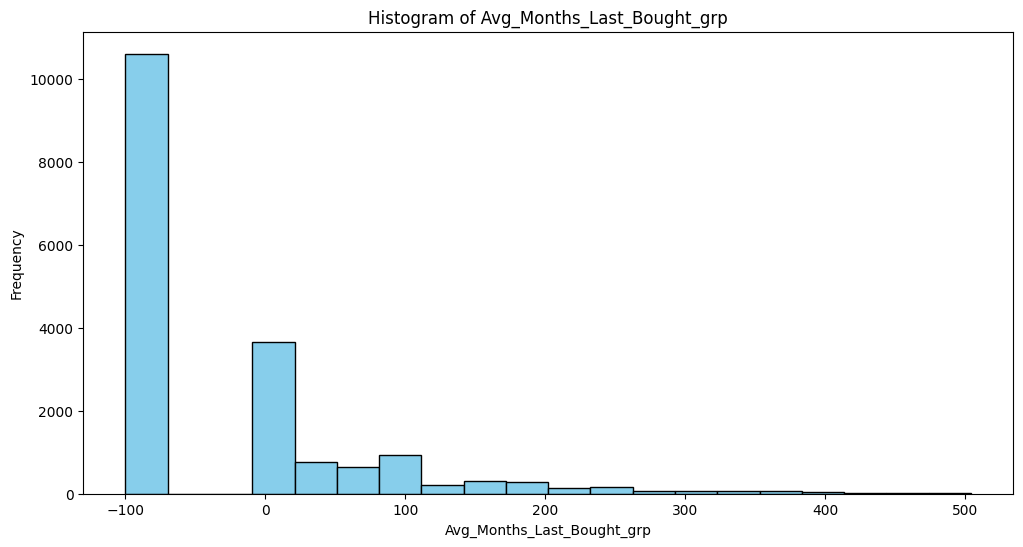

In [35]:
# Plot the histogram for grp
plt.figure(figsize=(12, 6))
plt.hist(n_months_last_bought_grp['Avg_Months_Last_Bought_grp'], bins = 20, color='skyblue', edgecolor='black')

# Set plot labels and title
plt.xlabel('Avg_Months_Last_Bought_grp')
plt.ylabel('Frequency')
plt.title('Histogram of Avg_Months_Last_Bought_grp')

# Show the plot
plt.show()

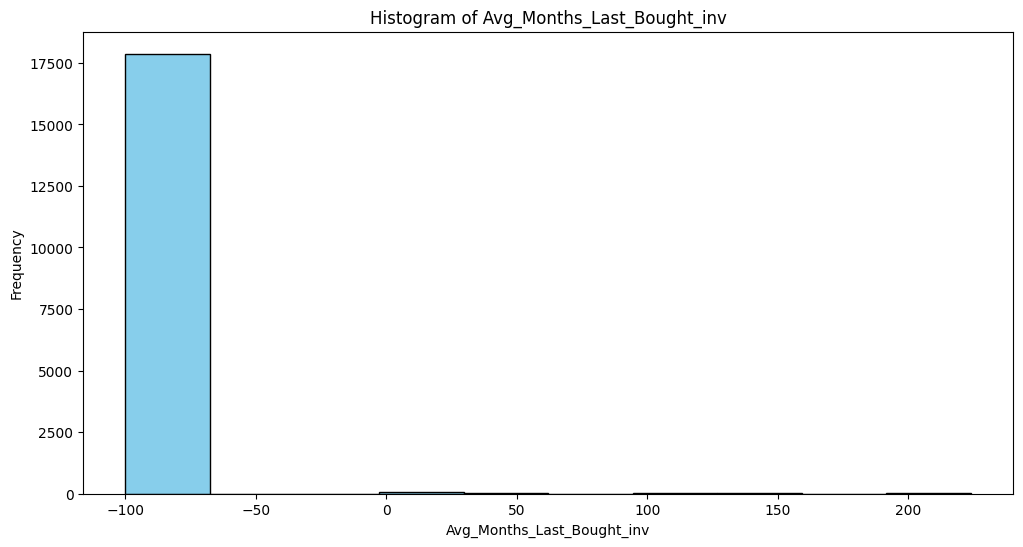

In [36]:
# Plot the histogram for inv
plt.figure(figsize=(12, 6))
plt.hist(n_months_last_bought_inv['Avg_Months_Last_Bought_inv'], bins = 10, color='skyblue', edgecolor='black')

# Set plot labels and title
plt.xlabel('Avg_Months_Last_Bought_inv')
plt.ylabel('Frequency')
plt.title('Histogram of Avg_Months_Last_Bought_inv')

# Show the plot
plt.show()

In [37]:
#convert float to object type
cleaned_df['flg_affconnect_show_interest_ever'] = cleaned_df['flg_affconnect_show_interest_ever'].astype('object')
cleaned_df['flg_affconnect_ready_to_buy_ever'] = cleaned_df['flg_affconnect_ready_to_buy_ever'].astype('object')
cleaned_df['flg_affconnect_lapse_ever'] = cleaned_df['flg_affconnect_lapse_ever'].astype('object')
cleaned_df['flg_hlthclaim_839f8a_ever'] = cleaned_df['flg_hlthclaim_839f8a_ever'].astype('object')
cleaned_df['flg_hlthclaim_14cb37_ever'] = cleaned_df['flg_hlthclaim_14cb37_ever'].astype('object')
cleaned_df['flg_hlthclaim_14cb37_ever'] = cleaned_df['flg_hlthclaim_14cb37_ever'].astype('object')

#convert some object cols to float 
cleaned_df['hlthclaim_amt'] = cleaned_df['hlthclaim_amt'].astype('float')
cleaned_df['giclaim_amt'] = cleaned_df['giclaim_amt'].astype('float')


#fill NaN in flag cols with 2
cleaned_df['flg_affconnect_show_interest_ever'] = cleaned_df['flg_affconnect_show_interest_ever'].fillna(2)
cleaned_df['flg_affconnect_ready_to_buy_ever'] = cleaned_df['flg_affconnect_ready_to_buy_ever'].fillna(2)
cleaned_df['flg_affconnect_lapse_ever'] = cleaned_df['flg_affconnect_lapse_ever'].fillna(2)
cleaned_df['flg_hlthclaim_839f8a_ever'] = cleaned_df['flg_hlthclaim_839f8a_ever'].fillna(2)
cleaned_df['flg_hlthclaim_14cb37_ever'] = cleaned_df['flg_hlthclaim_14cb37_ever'].fillna(2)

#cols to drop -  dropping individual policies
n_months_last_bought_cols_to_drop = ['n_months_last_bought_']

/var/folders/s8/h576kn8n48vd37_dt88pwm0w0000gn/T/ipykernel_21092/2589680416.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_df['flg_affconnect_show_interest_ever'] = cleaned_df['flg_affconnect_show_interest_ever'].fillna(2)
/var/folders/s8/h576kn8n48vd37_dt88pwm0w0000gn/T/ipykernel_21092/2589680416.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_df['flg_affconnect_ready_to_buy_ever'] = cleaned_df['flg_affconnect_ready_to_buy_ever'].fillna(2)
/var/folders/s8/h576kn8n48vd37_dt88pwm0w0000gn/T/ipykernel_21092/2589680416.py:17: Futur

# Analysing the average number of months since customer has lapsed a policy for each policy he/she has bought

In [38]:
# calculate the average 
def ave_months(row) :
    valid_months = [month for month in row if month != 9999]
    return np.mean(valid_months) if valid_months else np.nan

def cleaning(polType) :
    filtered = cleaned_df.filter(regex = 'n_months_since_lapse_' + polType, axis=1)
    filtered = filtered.apply(pd.to_numeric, errors = 'coerce') 
    filtered['avg_months_since_lapse_' + polType] = filtered.apply(ave_months, axis=1)
    return filtered


def count(temp) :
    count = 0
    for item in temp :
        if item != np.nan:
            count= count + 1
    return count

polTypeList = ['ltc', 'grp', 'inv', 'lh']

for item in polTypeList:
    temp = cleaning(item)
    print(f"The number of non-NaN value in {item} is {count(temp)}")

The number of non-NaN value in ltc is 3
The number of non-NaN value in grp is 15
The number of non-NaN value in inv is 3
The number of non-NaN value in lh is 7


Since the number of non-Nan Values for each policy type is almost negligible as compared to the number of rows, this means that the data on the number of months since lapse (n_months_since_lapse_) is majority missing when we were trying to find the average number of months since lapse for each policy type. Hence, it is decided that this type of column will be dropped.

In [39]:
n_months_since_lapse_cols_to_be_dropped = ['^n_months_since_lapse_']

# Analysing f_ever_bought

In [40]:
#function to agg f_ever_bought

def f_ever_bought_anl(pol_type):
    name = 'f_ever_bought_' + pol_type
    done_anl = cleaned_df.filter(regex=name, axis=1)
    cleaned_df['count_f_ever_bought_anl_' + pol_type] = done_anl.sum(axis=1)
    return cleaned_df


In [41]:
#creation of agg columns
polTypeList = ['ltc', 'grp', 'inv', 'lh']

for polType in polTypeList :
    cleaned_df = f_ever_bought_anl(polType)
    cleaned_df['count_f_ever_bought_anl_' + polType] = cleaned_df['count_f_ever_bought_anl_' + polType].astype('object')


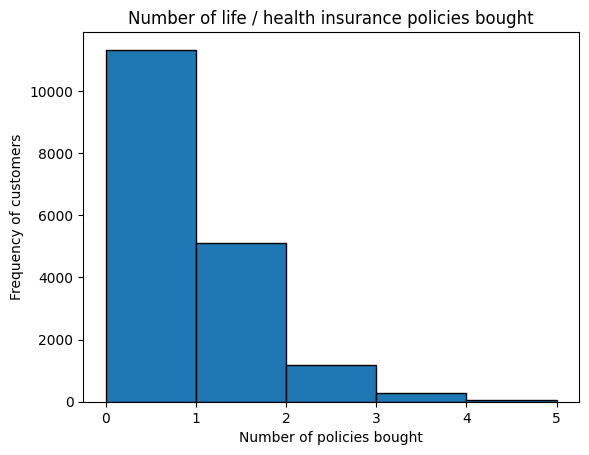

In [42]:
#Histogram for those that have ever bought a life/health insurance

data = cleaned_df['count_f_ever_bought_anl_lh']

# Create a histogram
plt.hist(data, bins=5, edgecolor='black')

# Add labels and title
plt.xlabel('Number of policies bought')
plt.ylabel('Frequency of customers')
plt.title('Number of life / health insurance policies bought')

# Show the plot
plt.show()

Majority of the customers have not bought a life/health insurance. However, about 25% of customers have at least bought 1 life/health insurance policy

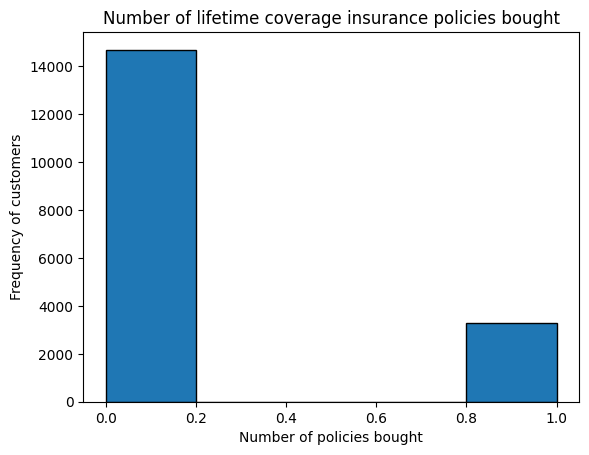

In [43]:
#Histogram for those that have ever bought a lifetime coverage

data = cleaned_df['count_f_ever_bought_anl_ltc']

# Create a histogram
plt.hist(data, bins=5, edgecolor='black')

# Add labels and title
plt.xlabel('Number of policies bought')
plt.ylabel('Frequency of customers')
plt.title('Number of lifetime coverage insurance policies bought')

# Show the plot
plt.show()

Majority of the people have not purchase lifetime coverage. Approximately 4000 customers have purchase 1 lifetime coverage plan

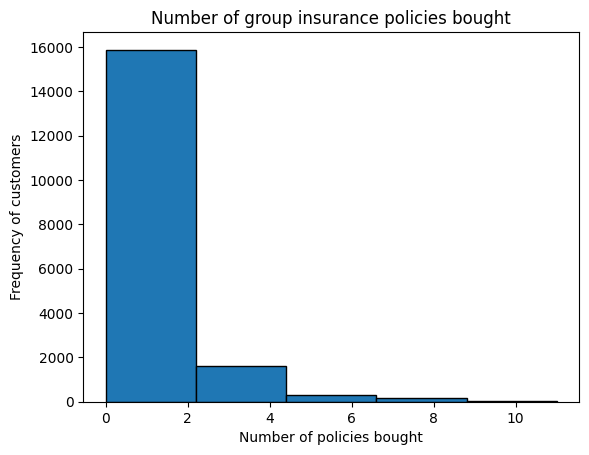

In [44]:
#Histogram for those that have ever bought a group insurance

data = cleaned_df['count_f_ever_bought_anl_grp']

# Create a histogram
plt.hist(data, bins=5, edgecolor='black')

# Add labels and title
plt.xlabel('Number of policies bought')
plt.ylabel('Frequency of customers')
plt.title('Number of group insurance policies bought')

# Show the plot
plt.show()

Most of the people have not purchase a group insurance before. Those that have ranges from buying 2 to 10 group insurances.

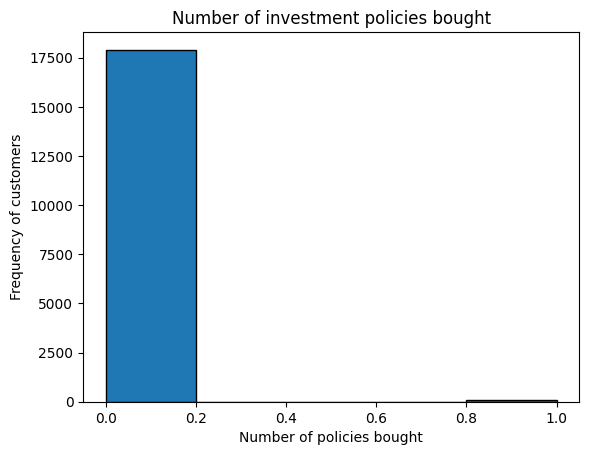

In [45]:
#Histogram for those that have ever bought an investment plan

data = cleaned_df['count_f_ever_bought_anl_inv']

# Create a histogram
plt.hist(data, bins=5, edgecolor='black')

# Add labels and title
plt.xlabel('Number of policies bought')
plt.ylabel('Frequency of customers')
plt.title('Number of investment policies bought')

# Show the plot
plt.show()

Most people have not bought an investment plan. Very few (Almost negligible) customers have bought an investment plan.

In [46]:
f_ever_bought_cols_to_drop =['^f_ever_bought_']

In [47]:
def checkNA(df):
    has_na = df.isna().any().any()
    if has_na:
        print("The DataFrame contains NaN values.")
    else:
        print("The DataFrame does not contain NaN values.")

checkNA(cleaned_df)

def findNA(df):
    for col in df.columns.tolist():
        if df[col].isna().any().any():
            index = test_df.columns.get_loc(col)
            percent = df[col].isna().sum() / len(df[col]) * 100
            print("{} still has na values, {}%".format(col, percent))
findNA(cleaned_df)

na_cols_to_be_dropped = test_df.iloc[:,278:303].columns.to_list()

The DataFrame contains NaN values.
lapse_ape_ltc_1280bf still has na values, 69.98666073810583%
lapse_ape_grp_6fc3e6 still has na values, 69.98666073810583%
lapse_ape_grp_de05ae still has na values, 69.98666073810583%
lapse_ape_inv_dcd836 still has na values, 69.98666073810583%
lapse_ape_grp_945b5a still has na values, 69.98666073810583%
lapse_ape_grp_6a5788 still has na values, 69.98666073810583%
lapse_ape_ltc_43b9d5 still has na values, 69.98666073810583%
lapse_ape_grp_9cdedf still has na values, 69.98666073810583%
lapse_ape_lh_d0adeb still has na values, 69.98666073810583%
lapse_ape_grp_1581d7 still has na values, 69.98666073810583%
lapse_ape_grp_22decf still has na values, 69.98666073810583%
lapse_ape_lh_507c37 still has na values, 69.98666073810583%
lapse_ape_lh_839f8a still has na values, 69.98666073810583%
lapse_ape_inv_e9f316 still has na values, 69.98666073810583%
lapse_ape_grp_caa6ff still has na values, 69.98666073810583%
lapse_ape_grp_fd3bfb still has na values, 69.98666073

These columns above contain a very high percentage(>90%) of null values, which will make our analysis less interpretable. Hence, we will drop all these columns. 

# Dropping of Columns after Analysis

In [48]:
cols_to_be_dropped = ape_columns_to_drop + sumins_columns_to_drop + n_months_last_bought_cols_to_drop + f_ever_bought_cols_to_drop + n_months_since_lapse_cols_to_be_dropped + na_cols_to_be_dropped
len(cols_to_be_dropped)

columns_to_drop = cleaned_df.filter(regex='|'.join(cols_to_be_dropped)).columns
columns_to_drop.tolist()

cleaned_df = cleaned_df.drop(columns = columns_to_drop)

# Helper functions for checking of column types

In [49]:
def checkTypes():
    types = cleaned_df.dtypes.tolist()
    cols = cleaned_df.columns.tolist()
    for i in range(len(types)):
        print("{} : {}".format(cols[i], types[i]))

colsToNumeric = ['tot_ape_gi','tot_ape_lh','tot_ape_ltc', 'tot_ape_grp' ,'tot_ape_inv'
, 'tot_sumsin_gi', 'tot_sumsin_lh', 'tot_sumsin_ltc', 'tot_sumsin_grp', 'tot_sumsin_inv', 
'count_f_ever_bought_anl_ltc', 'count_f_ever_bought_anl_grp', 'count_f_ever_bought_anl_inv',
'count_f_ever_bought_anl_lh', 'days_since_min_occ_date'] 

##add on if u want to convert column to numeric
def convertToNumeric(colNames, df):
    cleaned_df = df
    for name in colNames:
        cleaned_df[name] = pd.to_numeric(cleaned_df[name], errors='coerce')
    return cleaned_df

colsToObject = ['flg_substandard', 'flg_is_borderline_standard',
                'flg_is_rental_flat', 'flg_has_health_claim', 'flg_has_life_claim', 'flg_gi_claim', 
                'flg_is_proposal', 'flg_with_preauthorisation', 'is_sg_pr',
                'f_ever_declined_la', 'flg_latest_being_lapse',
                'flg_latest_being_cancel']

##add on if u want to convert column to object
def convertToObject(colNames, df):
    cleaned_df = df
    for name in colNames:
        cleaned_df[name] = cleaned_df[name].astype(str)
    return cleaned_df

cleaned_df = convertToNumeric(colsToNumeric, cleaned_df)
cleaned_df = convertToObject(colsToObject, cleaned_df)
checkTypes()


clttype : object
stat_flag : object
days_since_min_occ_date : int64
cltdob_fix : object
flg_substandard : object
flg_is_borderline_standard : object
flg_is_rental_flat : object
flg_has_health_claim : object
flg_has_life_claim : object
flg_gi_claim : object
flg_is_proposal : object
flg_with_preauthorisation : object
is_sg_pr : object
f_ever_declined_la : object
hh_size : float64
annual_income_est : object
flg_latest_being_lapse : object
flg_latest_being_cancel : object
recency_lapse : float64
recency_cancel : float64
tot_inforce_pols : int64
tot_cancel_pols : float64
f_elx : int64
f_mindef_mha : int64
f_retail : int64
flg_affconnect_show_interest_ever : float64
flg_affconnect_ready_to_buy_ever : float64
flg_affconnect_lapse_ever : float64
is_contactable : object
is_valid : object
tot_ape_gi : float64
tot_ape_lh : float64
tot_ape_ltc : float64
tot_ape_grp : float64
tot_ape_inv : float64
tot_sumsin_gi : float64
tot_sumsin_lh : float64
tot_sumsin_ltc : float64
tot_sumsin_grp : float64
tot_

In [50]:
# lst = ['flg_substandard', 'flg_is_borderline_standard', 'flg_gi_claim', 'flg_with_preauthorisation', 
#        'f_elx', 'f_mindef_mha', 'f_retail', 'flg_affconnect_show_interest_ever', 'flg_affconnect_ready_to_buy_ever', 
#        'flg_affconnect_lapse_ever', 'count_f_ever_bought_anl_ltc', 'count_f_ever_bought_anl_grp', 'count_f_ever_bought_anl_inv', 'tot_sumsin_inv',
#        'tot_sumsin_grp', 'tot_sumsin_ltc','tot_sumsin_gi', 'is_contactable', 'is_valid', 'clttype', 'stat_flag', 'cltdob_fix', 
#        'annual_income_est']
# cleaned_df=dropCols(lst, cleaned_df)

# Checking if data still contains NA values

In [51]:
def checkNA(df):
    has_na = df.isna().any().any()
    if has_na:
        print("The DataFrame contains NaN values.")
    else:
        print("The DataFrame does not contain NaN values.")
checkNA(cleaned_df)
def findNA(df):
    for col in df.columns.tolist():
        if df[col].isna().any().any():
            index = test_df.columns.get_loc(col)
            percent = df[col].isna().sum() / len(df[col]) * 100
            print("index {}: {} still has na values, {}%".format(index, col, percent))
findNA(cleaned_df)
checkTypes()
print(len(cleaned_df.columns))

The DataFrame does not contain NaN values.
clttype : object
stat_flag : object
days_since_min_occ_date : int64
cltdob_fix : object
flg_substandard : object
flg_is_borderline_standard : object
flg_is_rental_flat : object
flg_has_health_claim : object
flg_has_life_claim : object
flg_gi_claim : object
flg_is_proposal : object
flg_with_preauthorisation : object
is_sg_pr : object
f_ever_declined_la : object
hh_size : float64
annual_income_est : object
flg_latest_being_lapse : object
flg_latest_being_cancel : object
recency_lapse : float64
recency_cancel : float64
tot_inforce_pols : int64
tot_cancel_pols : float64
f_elx : int64
f_mindef_mha : int64
f_retail : int64
flg_affconnect_show_interest_ever : float64
flg_affconnect_ready_to_buy_ever : float64
flg_affconnect_lapse_ever : float64
is_contactable : object
is_valid : object
tot_ape_gi : float64
tot_ape_lh : float64
tot_ape_ltc : float64
tot_ape_grp : float64
tot_ape_inv : float64
tot_sumsin_gi : float64
tot_sumsin_lh : float64
tot_sumsin_

# Using K-Prototype Clustering (NOT WORKING YET IS JUST EMPTY CODE)

After feature engineering, we will proceed to utilise machine learning methods to predict the outcome variable `f_purchase_lh`. Here, due to a mixture of categorical and numeric features in the dataset, we will use K-Prototype Clustering, an improvement from the K-Means and K-Mode clustering algorithm to handle clustering with the mixed data types.

In [52]:
#import libraries
from kmodes.kprototypes import KPrototypes
from plotnine import *
import plotnine

In [53]:
# Get the position of categorical columns
categorical_indices = [cleaned_df.columns.get_loc(col) for col in cleaned_df.select_dtypes(include='object').columns]

numeric_matrix = cleaned_df.drop(cleaned_df.columns[categorical_indices], axis=1)
categorical_matrix = cleaned_df.iloc[:, categorical_indices].values

In [54]:
dfMatrix = cleaned_df.to_numpy()

In [65]:
# Get the position of categorical columns
categorical_indices = [cleaned_df.columns.get_loc(col) for col in cleaned_df.select_dtypes(include='object').columns]

# Extract numeric and categorical matrices
numeric_matrix = cleaned_df.drop(cleaned_df.columns[categorical_indices], axis=1)
categorical_matrix = cleaned_df.iloc[:, categorical_indices]

# Concatenate numeric and categorical matrices into a single DataFrame
combined_df = pd.concat([numeric_matrix, categorical_matrix], axis=1)

In [199]:
# Choosing the optimal number of clusters, K
cost = []
for cluster in range(1, 8):
    try:
        kprototype = KPrototypes(n_clusters=cluster, init='Huang', verbose=2, random_state=42,max_iter=10, n_init=5, 
                                 gamma=.25)
        
        # Fit and predict with KPrototypes
        clusters = kprototype.fit_predict(combined_df, categorical=list(range(len(numeric_matrix.columns), len(numeric_matrix.columns) + len(categorical_indices))))
        
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except Exception as e:
        print(e)
        break

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/10, moves: 0, ncost: 1.3342325177774124e+16
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/10, moves: 0, ncost: 1.3342325177774124e+16
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/10, moves: 0, ncost: 1.3342325177774124e+16
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/10, moves: 0, ncost: 1.3342325177774124e+16
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/10, moves: 0, ncost: 1.3342325177774124e+16
Best run was number 1
Cluster initiation: 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/10, moves: 802, ncost: 1.1642656574025862e+16
Run: 1, iteration: 2/10, moves: 280, ncost: 1.1609234349042262e+16
Run: 1, iteration

In [201]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 8), 'Cost':cost})
df_cost.head()

,Cluster,Cost
0,1,1.334233e+16
1,2,6.384024e+15
2,3,4.377899e+15
3,4,2.760573e+15
4,5,2.060549e+15


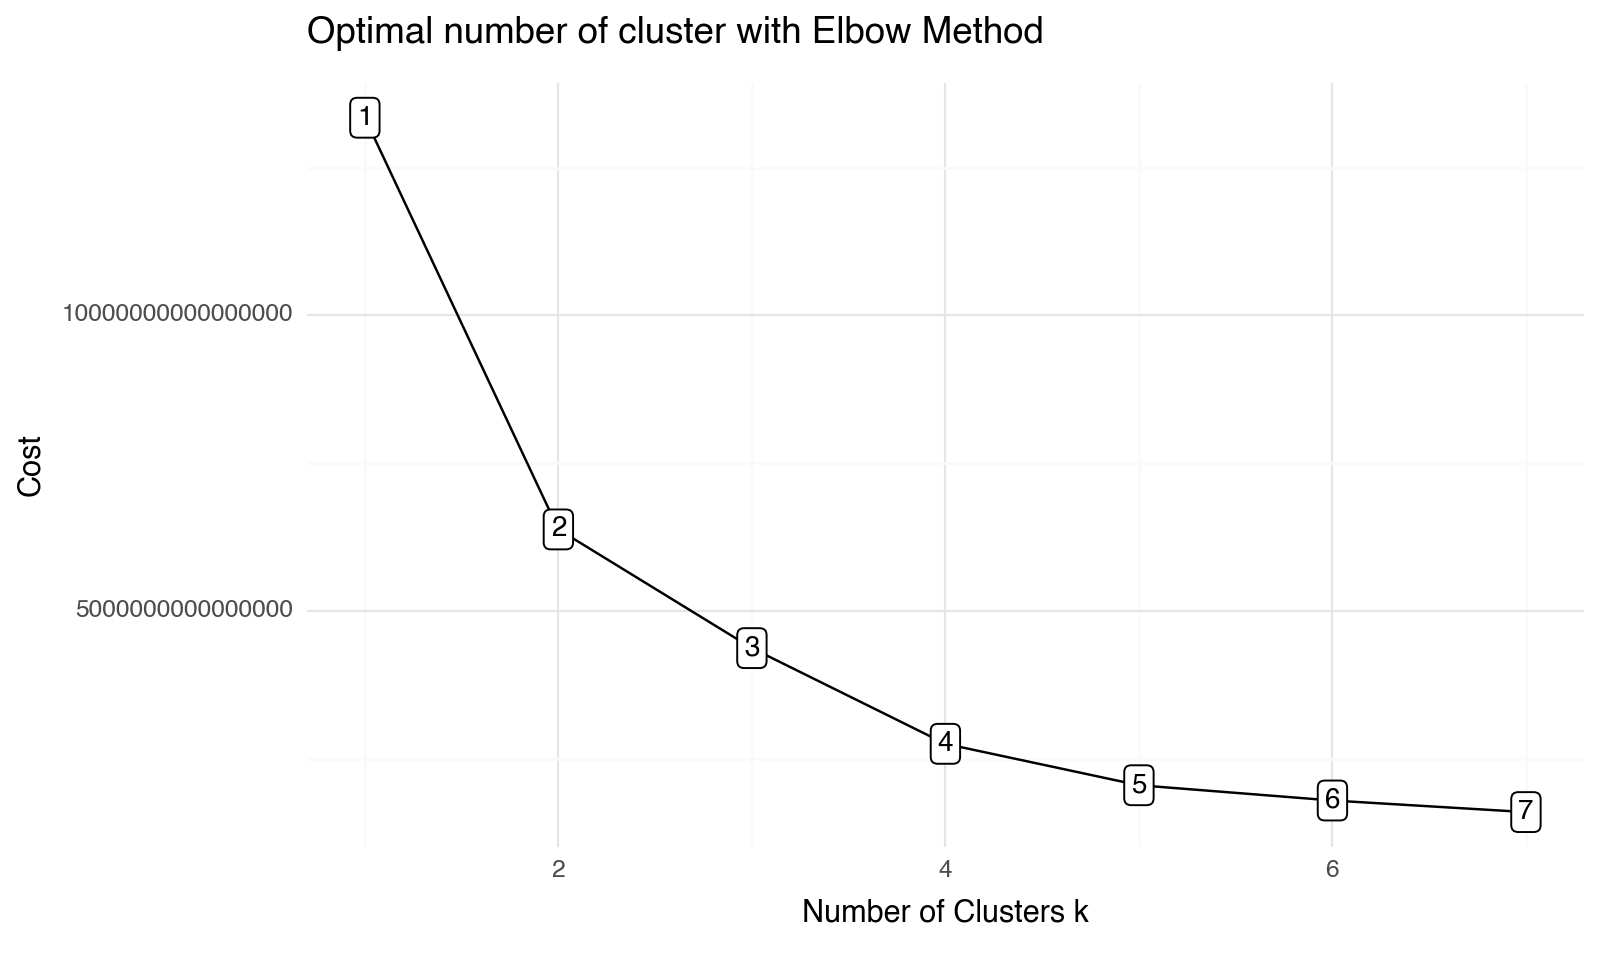

<Figure Size: (800 x 480)>

In [213]:
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)
# we will choose k = 2 since it is the elbow

In [66]:
# Fit the cluster
kprototype =  KPrototypes(n_clusters=2, init='Huang', verbose=2, random_state=42)
kprototype.fit_predict(dfMatrix, categorical = categorical_indices)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 802, ncost: 1.1642657956830154e+16
Run: 1, iteration: 2/100, moves: 280, ncost: 1.1609235731846382e+16
Run: 1, iteration: 3/100, moves: 97, ncost: 1.1549899189058098e+16
Run: 1, iteration: 4/100, moves: 1054, ncost: 8162448405449954.0
Run: 1, iteration: 5/100, moves: 1075, ncost: 6494785549791221.0
Run: 1, iteration: 6/100, moves: 206, ncost: 6389681990183872.0
Run: 1, iteration: 7/100, moves: 46, ncost: 6384052641556088.0
Run: 1, iteration: 8/100, moves: 3, ncost: 6384025687799051.0
Run: 1, iteration: 9/100, moves: 0, ncost: 6384025687799051.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 3151, ncost: 7498917819753619.0
Run: 2, iteration: 2/100, moves: 858, ncost: 6469421247205701.0
Run: 2, iteration: 3/100, moves: 192, ncost: 6388602948227020.0
Run: 2, iteration: 4/100, moves: 41, ncost: 6384052641556088.0


array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

In [84]:
count_zeros = np.sum(kprototype.labels_ == 0)
count_ones = np.sum(kprototype.labels_ == 1)

print(f"Number of 0s: {count_zeros}") # Cluster 1
print(f"Number of 1s: {count_ones}") # Cluster 2

Number of 0s: 17175
Number of 1s: 817


In [74]:
# Cluster centorid
kprototype.cluster_centroids_
cluster_df = pd.DataFrame(data = kprototype.cluster_centroids_, columns = numeric_matrix.columns.tolist() + categorical_matrix.columns.tolist())

In [76]:
columns_to_drop = cluster_df.columns[cluster_df.apply(pd.Series.nunique) == 1]
cluster_df = cluster_df.drop(columns=columns_to_drop)
cluster_df

,days_since_min_occ_date,hh_size,recency_lapse,recency_cancel,tot_inforce_pols,tot_cancel_pols,f_elx,f_mindef_mha,f_retail,flg_affconnect_show_interest_ever,flg_affconnect_ready_to_buy_ever,flg_affconnect_lapse_ever,tot_ape_lh,tot_ape_ltc,tot_ape_grp,tot_ape_inv,tot_sumsin_lh,tot_sumsin_ltc,tot_sumsin_grp,tot_sumsin_inv,count_f_ever_bought_anl_ltc,count_f_ever_bought_anl_grp,count_f_ever_bought_anl_inv,count_f_ever_bought_anl_lh,cltdob_fix,is_contactable
0,3174.520116448326,3.244077017921993,22.93443959243086,1.544919941775837,2.2819796215429404,0.03918486171761281,0.2358660844250364,0.10171761280931586,0.7669868995633188,1.986259097525473,1.9736826783114993,1.9476564774381369,969.0935790393013,107.51825327510917,168.2981834061142,64.12245123726348,107611.81845705968,220.0509461426492,77411.50119243086,511.6740232896653,0.1838136826783115,0.5838136826783115,0.004541484716157205,0.47860262008733623,None,False
1,4718.012239902081,3.0612454799725084,26.761321909424726,4.156670746634027,7.2276621787025706,0.10648714810281518,0.10893512851897184,0.9608323133414932,0.5422276621787026,1.6829865361077112,1.5569155446756426,1.1187270501835986,808.9036719706204,114.12484700122398,1877.6151162790668,56.303549571603426,124526.87025703794,255.66829865361078,3064339.9669522643,0.0,0.17870257037943696,4.690330477356182,0.004895960832313341,0.48714810281517745,1990-02-01,True


Viewing the cluster centroids we analyse the following columns that have a significant difference between each cluster group.

recency_cancel : Customers in cluster 1 tend to have recently cancelled certain policies
tot_inforce_pols:  Customers in cluster 2 have more polices in place as compared to customers in cluster 1
tot_cancel_pols: Customers in cluster 2 have a higher tendency to cancel policies and are thus likely to switch from policy to policy.
tot_ape: Customers in client 2 are paying higher APE across all policy types (lh, ltc, grp, inv) and are more covered by a higher sum_insured (especially tot_sumsin_grp). Customers in cluster 1 are paying a higher APE for Life/health insurance as compared to cluster 2.
is_contactable: The majority of clients in cluster 2 are contactable as compared to customers in client 1. This makes it difficult for the insurance company to contact them to sell their life / health insurance products.

Based on the above analysis, we believe that customers in cluster 2 are more likely to purchase life / health insurance. We will thus be assigning the label of 1 to customers belonging in cluster 2 and label of 0 to customers belonging in cluster 1.




In [86]:
cleaned_df['pred_f_purchase_lh'] = kprototype.labels_
cleaned_df['pred_f_purchase_lh']

19550    0
4600     0
13337    0
15074    0
19724    0
        ..
11284    0
11964    0
5390     0
860      0
15795    0
Name: pred_f_purchase_lh, Length: 17992, dtype: uint16